In [2]:
# STDP unsupervised SNN learning model
# Non-compressed
# Digit recognition (MNIST)

import numpy as np 
import struct
import matplotlib.pyplot as plt
import csv

from brian2 import *

%matplotlib inline

In [2]:
# Run cell 2 and 3 if no input file provided
# run cell 4 if input file is provided

In [3]:
# Read MNIST data set (Training)

with open("../data/MNIST/train/train-images.idx3-ubyte", 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype = np.dtype(np.uint8).newbyteorder('>'))
    data = data.reshape((size, nrows, ncols))
print("Training size = {0}".format(len(data)))

Training size = 60000


In [16]:
# read in training data

batch_tot = 1

data_train = []

n_input = 0
n_sample = 0

for batch_index in range(batch_tot):
    with open("./pst_train_{0}.txt".format(batch_index), "r") as f:
        n_inputNeuron, n_newSample = [int(x) for x in next(f).split()]
        if (batch_index == 0):
            n_input = n_inputNeuron
        n_sample = n_sample + n_newSample
        for line in f:
            data_train.append([float(x) for x in line.split()])


0.0

WARNING    "vt_exc" is an internal variable of group "neurongroup_6", but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


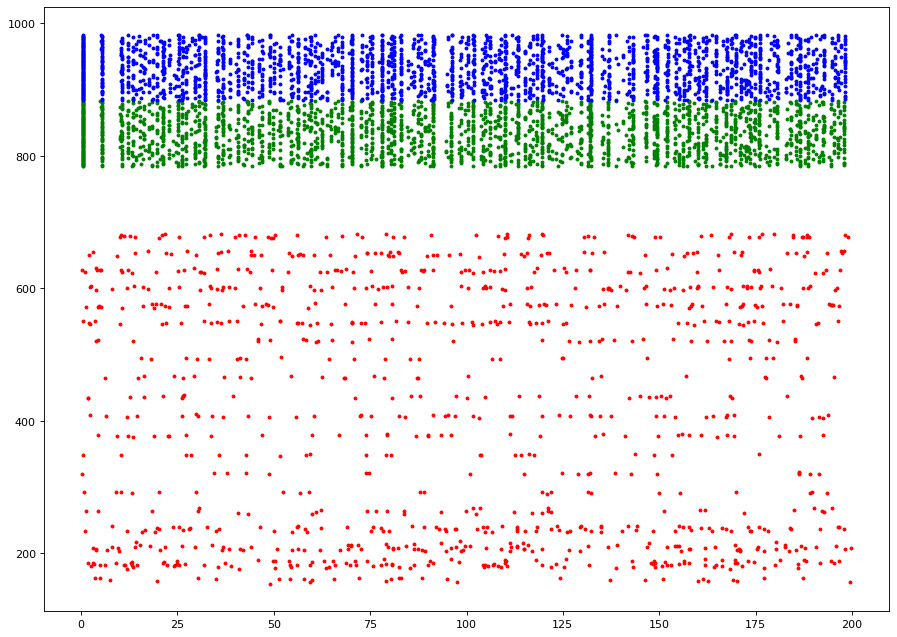

In [31]:
# Network Construction
start_scope()


# set up input neurons

rate_multiplier = 1*Hz

input_layer = PoissonGroup(n_input, data_train[0]*rate_multiplier)


# set up excitatory neurons

tau_exc = 100*ms
vt_exc = 0
vt_exc_rest = 0.5
vt_exc_inc = 0.1
vt_exc_tau = 50*ms
vt_exc_max = 1

eqs_exc = '''
dv/dt = -v/tau_exc : 1
dvt_exc/dt = -vt_exc/vt_exc_tau : 1
'''

exc_layer = NeuronGroup(
    100, eqs_exc, 
    threshold="v>vt_exc + vt_exc_rest", 
    refractory="5*ms", 
    reset="v=0", 
    method="exact", 
    events={"homeo" : "v>vt_exc + vt_exc_rest"})

exc_layer.run_on_event("homeo", "vt_exc += vt_exc_inc")


# set up inhibitory neuron

tau_inh = 75*ms
vt_inh = 0.2

eqs_inh = '''
dv/dt = -v/tau_inh : 1
'''

inh_layer = NeuronGroup(
    100, 
    eqs_inh, 
    threshold="v>vt_inh", 
    refractory="5*ms", 
    reset="v=0", 
    method="exact")

# Synapses from input layer to excitatory layer

t_post = 0

input_dynamics = '''
w : 1
'''

input_pre_action = '''
pre_last = t
v_post += w
'''

input_post_action = '''
delta_w = 0.1 * exp((pre_last - t) / taupre) - 1
w = clip(w + delta_w, -1, 1)
'''

input_s = Synapses(
    input_layer, 
    exc_layer, 
    input_dynamics,
    on_pre = input_pre_action,
    on_post = input_post_action)

input_s.connect()

# Initialize / Randomize input synapses
for src_index in range(n_input):
    for dst_index in range(100):
        input_s.w[src_index, dst_index] = uniform(0.1, 0.9)
input_s.pre_last = 0

exc_s = Synapses(
    exc_layer, 
    inh_layer, 
    on_pre = "v_post += 0.5")

exc_s.connect(condition = "i == j")

inh_s = Synapses(
    inh_layer, 
    exc_layer, 
    on_pre = "v_post -= 0.2")

inh_s.connect(condition = "i != j")

input_spike = SpikeMonitor(input_layer)
exc_spike = SpikeMonitor(exc_layer)
inh_spike = SpikeMonitor(inh_layer)

#exc_state = StateMonitor(exc_layer, 'v', record = True)
#inh_state = StateMonitor(inh_layer, 'v', record = True)

run(200*ms)

figure(figsize = (30, 10), dpi=80, facecolor = 'w', edgecolor = 'k')
subplot(1,2,1)
plot(input_spike.t/ms, input_spike.i, '.r', ms=5)
plot(exc_spike.t/ms, exc_spike.i + n_input, '.g', ms=5)
plot(inh_spike.t/ms, inh_spike.i + n_input + 100, '.b', ms=5)



In [23]:
len(input_s)

78400

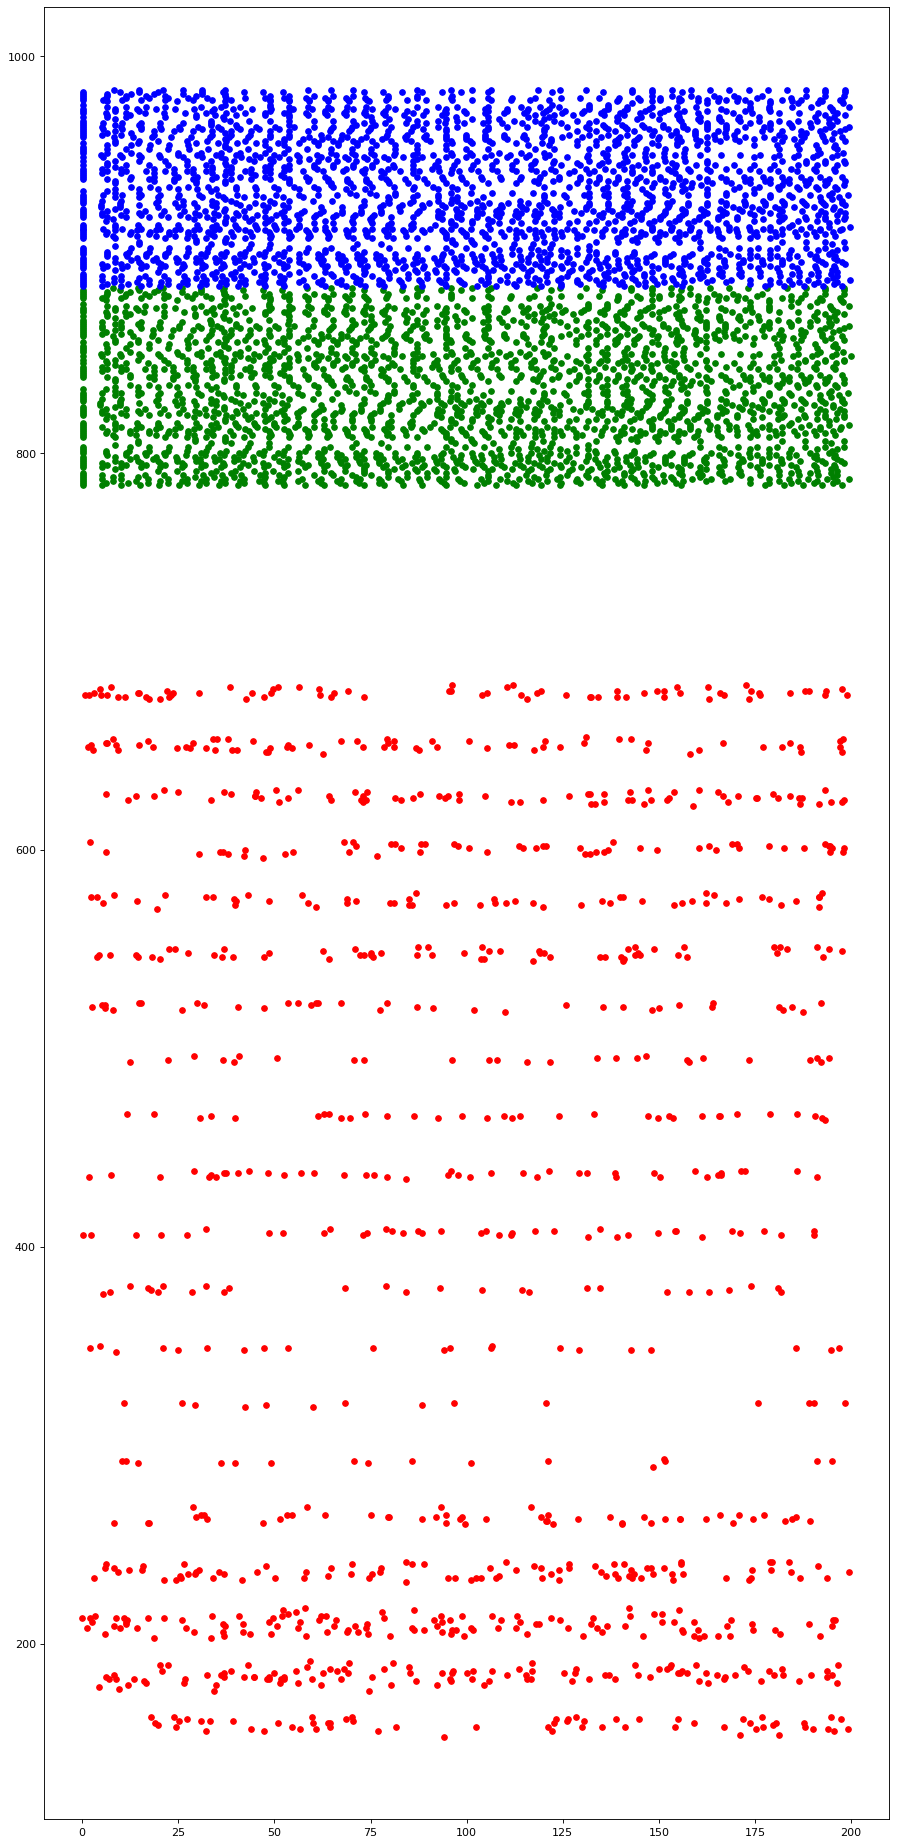

In [26]:
figure(figsize = (30, 30), dpi=80, facecolor = 'w', edgecolor = 'k')
subplot(1,2,1)
plot(input_spike.t/ms, input_spike.i, '.r', ms=10)
plot(exc_spike.t/ms, exc_spike.i + n_input, '.g', ms=10)
plot(inh_spike.t/ms, inh_spike.i + n_input+100, '.b', ms=10)

In [ ]:
# Network Construction
start_scope()


# set up input neurons

rate_multiplier = 1*Hz

input_layer = PoissonGroup(2, [10, 20]*rate_multiplier)


# set up excitatory neurons

tau_exc = 100*ms
vt_exc_0 = 0.3

eqs_exc = '''
dv/dt = -v/tau_exc : 1
'''

exc_layer = NeuronGroup(2, eqs_exc, threshold="v>0.1", refractory="5*ms", reset="v=0", method="exact")

input_s = Synapses(input_layer, exc_layer, on_pre = "v_post += 0.4")
input_s.connect()

input_spike = SpikeMonitor(input_layer)
exc_spike = SpikeMonitor(exc_layer)

exc_state = StateMonitor(exc_layer, 'v', record = True)

run(200*ms)

figure(figsize = (30, 10), dpi=80, facecolor = 'w', edgecolor = 'k')
subplot(1,2,1)
plot(input_spikes.t/ms, input_spikes.i, '.r', ms=20)
plot(exc_spikes.t/ms, exc_spikes.i + n[0], '.g', ms=20)

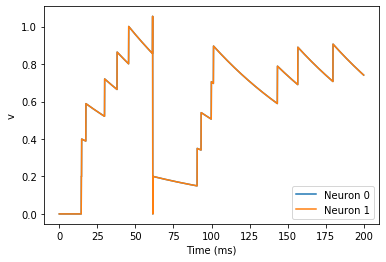

In [14]:
start_scope()

rate_multiplier = 1*Hz

input_layer = PoissonGroup(2, [20, 50]*rate_multiplier)

tau = 100*ms

eqs = '''
dv/dt = -v/tau : 1
'''

G = NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', refractory="5*ms", method='exact')
# G.tau = [10, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(input_layer, G, on_pre='v_post += 0.2')
S.connect()

M = StateMonitor(G, 'v', record=True)
S = 

run(200*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend();

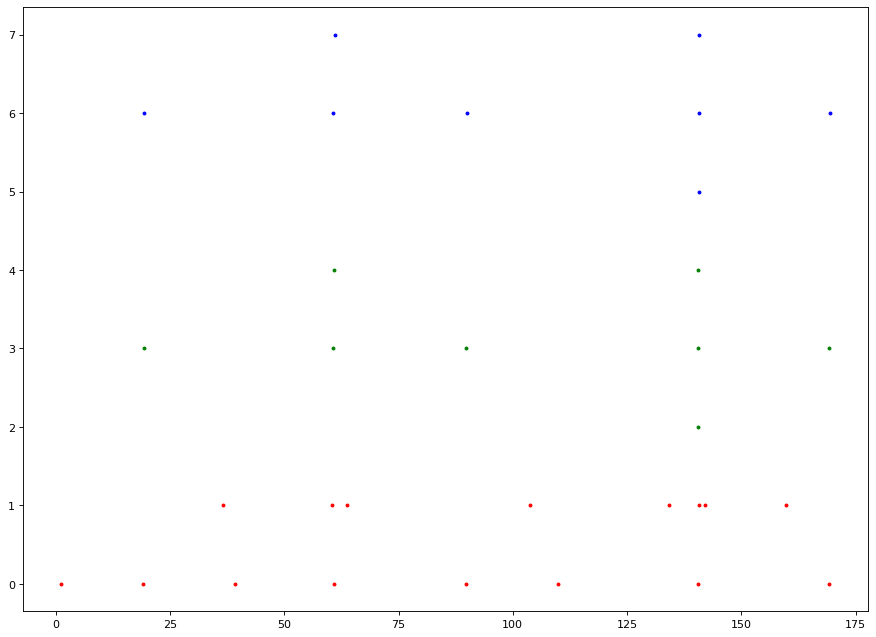

In [16]:
# Network Construction
start_scope()

# set up input neurons

n_input = 2

rate_multiplier = 1*Hz

input_layer = PoissonGroup(2, [50, 25]*rate_multiplier)


# set up excitatory neurons

tau_exc = 100*ms
vt_exc = 0.5
vt_exc_rest = 0.5
vt_exc_inc = 0.1
vt_exc_tau = 200*ms

eqs_exc = '''
dv/dt = -v/tau_exc : 1
dvt_exc/dt = (vt_exc_rest-vt_exc)/vt_exc_tau : 1
'''

exc_layer = NeuronGroup(3, eqs_exc, threshold="v>vt_exc + vt_exc_null", refractory="5*ms", reset="v=0", method="exact", events={"homeo" : "v>vt_exc"})
exc_layer.vt_exc = 0.5

exc_layer.run_on_event("homeo", "vt_exc = clip(vt_exc + vt_exc_inc, 0, 1)")


# set up inhibitory neuron

tau_inh = 75*ms
vt_inh = 0.2

eqs_inh = '''
dv/dt = -v/tau_inh : 1
'''

inh_layer = NeuronGroup(3, eqs_inh, threshold="v>vt_inh", refractory="5*ms", reset="v=0", method="exact")

# Synapses from input layer to excitatory layer
input_s = Synapses(input_layer, exc_layer, "w : 1",
            on_pre = '''v_post += w''')
input_s.connect()

# Initialize / Randomize input synapses
for src_index in range(n_input):
    for dst_index in range(100):
        input_s.w[src_index, dst_index] = uniform(0.1, 0.9)

exc_s = Synapses(exc_layer, inh_layer, on_pre = "v_post += 0.5")
exc_s.connect(condition = "i == j")

inh_s = Synapses(inh_layer, exc_layer, on_pre = "v_post -= 0.2")
inh_s.connect(condition = "i != j")

input_spike = SpikeMonitor(input_layer)
exc_spike = SpikeMonitor(exc_layer)
inh_spike = SpikeMonitor(inh_layer)

exc_vt = StateMonitor(exc_layer, "vt_exc", record=True)

#exc_state = StateMonitor(exc_layer, 'v', record = True)
#inh_state = StateMonitor(inh_layer, 'v', record = True)

run(200*ms)

figure(figsize = (30, 10), dpi=80, facecolor = 'w', edgecolor = 'k')
subplot(1,2,1)
plot(input_spike.t/ms, input_spike.i, '.r', ms=5)
plot(exc_spike.t/ms, exc_spike.i + 2, '.g', ms=5)
plot(inh_spike.t/ms, inh_spike.i + 5, '.b', ms=5)



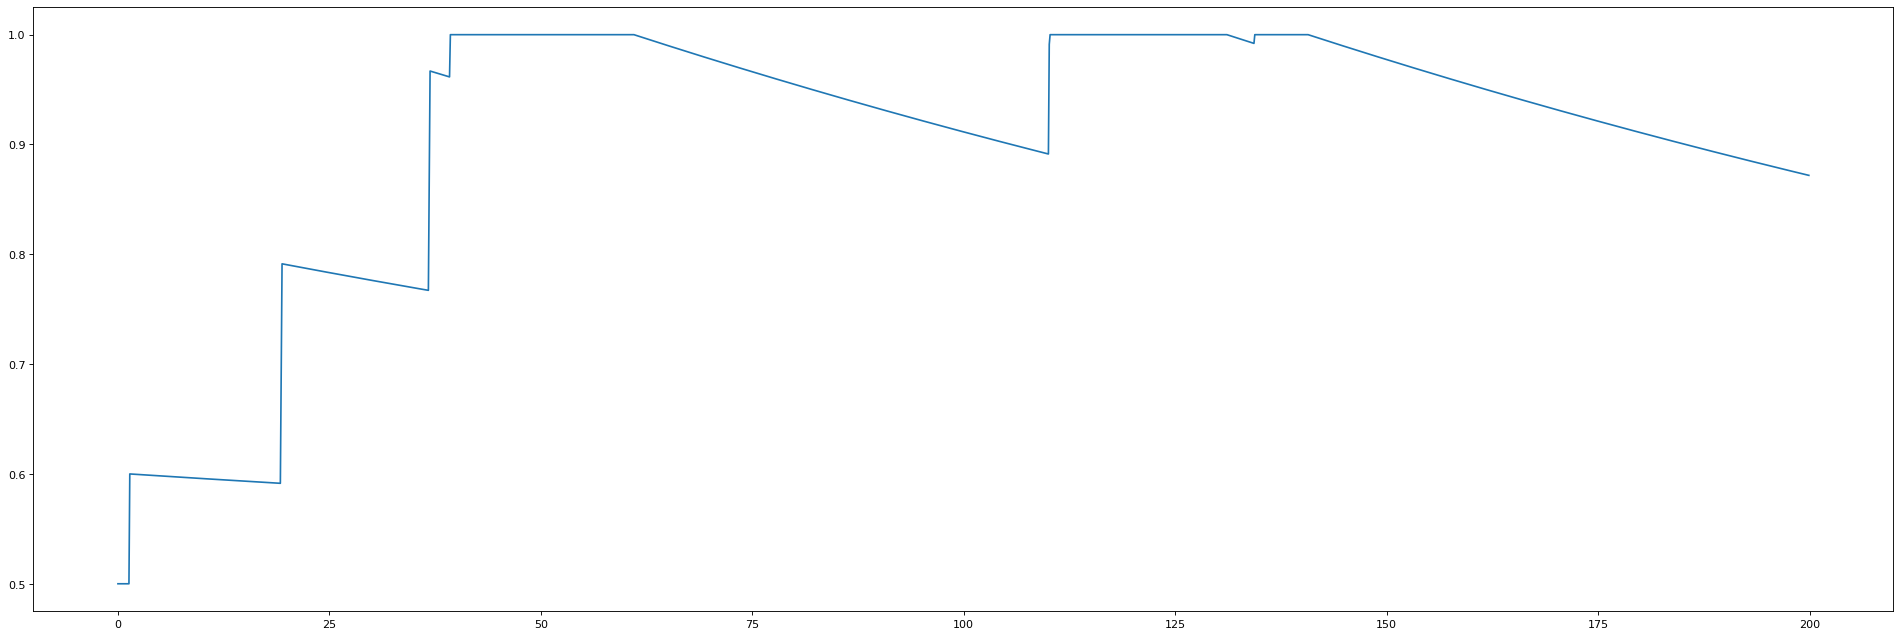

In [17]:
figure(figsize = (30, 10), dpi=80, facecolor = 'w', edgecolor = 'k')
plot(exc_vt.t/ms, exc_vt.vt_exc[2])

In [104]:
# Network Construction
start_scope()

# set up input neurons

n_input = 10

rate_multiplier = 1*Hz

input_layer = PoissonGroup(n_input, [10, 0, 5, 7, 12, 0, 100, 45, 30, 15]*rate_multiplier)


# set up excitatory neurons

tau_exc = 100*ms
vt_exc_rest = 0.2
vt_exc_inc = 0.2
vt_exc_tau = 200*ms

eqs_exc = '''
dv/dt = -v/tau_exc : 1
dvt_exc/dt = (vt_exc_rest-vt_exc)/vt_exc_tau : 1
'''

exc_layer = NeuronGroup(1, eqs_exc, threshold="v>vt_exc", refractory="5*ms", reset="v=0", method="exact", events={"homeo" : "v>vt_exc"})
exc_layer.vt_exc = 0.2

exc_layer.run_on_event("homeo", "vt_exc = clip(vt_exc + vt_exc_inc, 0, 1)")

delta_w = 0.01

taupre = 30 * ms
taupost = taupre
gmax = 0.5
dApre = 0.1
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax 
dApre *= gmax


synapse_dynamic = '''
w : 1
delta_w : 1
pre_last : second
'''

synapse_pre_action = '''
pre_last = t
v_post += w
'''

# synapse_post_action = '''
# Apost += dApost
# w = clip(w + Apre, 0, gmax)
# '''

synapse_post_action = '''
delta_w = 0.01 * (2 * exp((pre_last - t) / taupre) - 1)
w = clip(w + delta_w, 0, 1)
'''

# Synapses from input layer to excitatory layer
input_s = Synapses(
    input_layer, 
    exc_layer, 
    synapse_dynamic,
    on_pre = synapse_pre_action,
    on_post = synapse_post_action)

input_s.connect()

# Initialize / Randomize input synapses
for src_index in range(n_input):
    for dst_index in range(exc_layer.N):
        input_s.w[src_index, dst_index] = uniform(0.1, 0.2)

input_spike = SpikeMonitor(input_layer)
exc_spike = SpikeMonitor(exc_layer)



pre_update_t = StateMonitor(input_s, "pre_last", record=True)

input_w = StateMonitor(input_s, "w", record=True)

delta_w_mo = StateMonitor(input_s, "delta_w", record=True)

exc_v = StateMonitor(exc_layer, "v", record=True)

exc_vt = StateMonitor(exc_layer, "vt_exc", record=True)

#exc_state = StateMonitor(exc_layer, 'v', record = True)
#inh_state = StateMonitor(inh_layer, 'v', record = True)

run(200*ms)





Text(0.5, 1.0, 'Input Synapse Last pre update time')

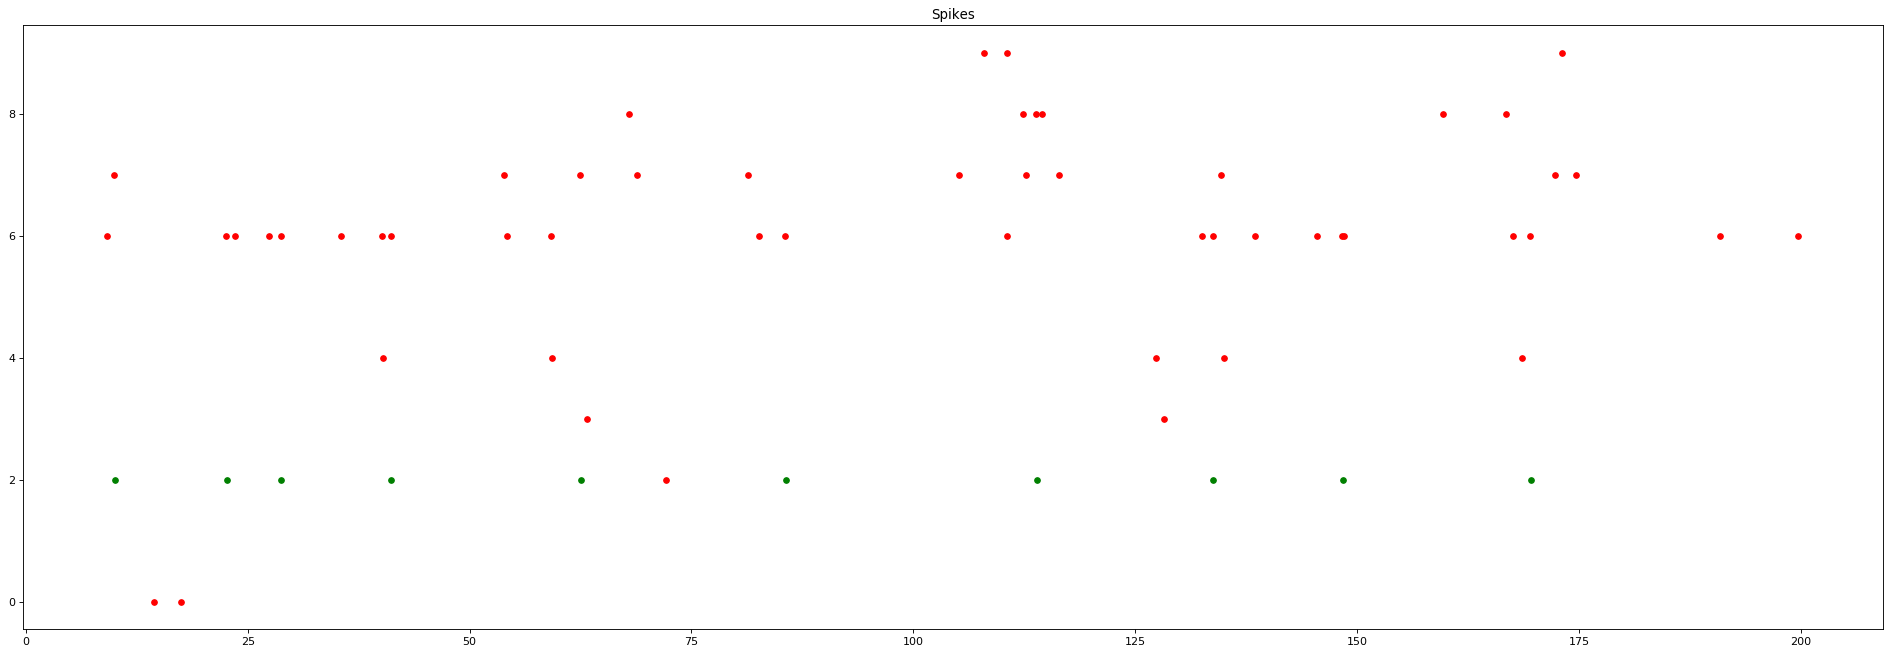

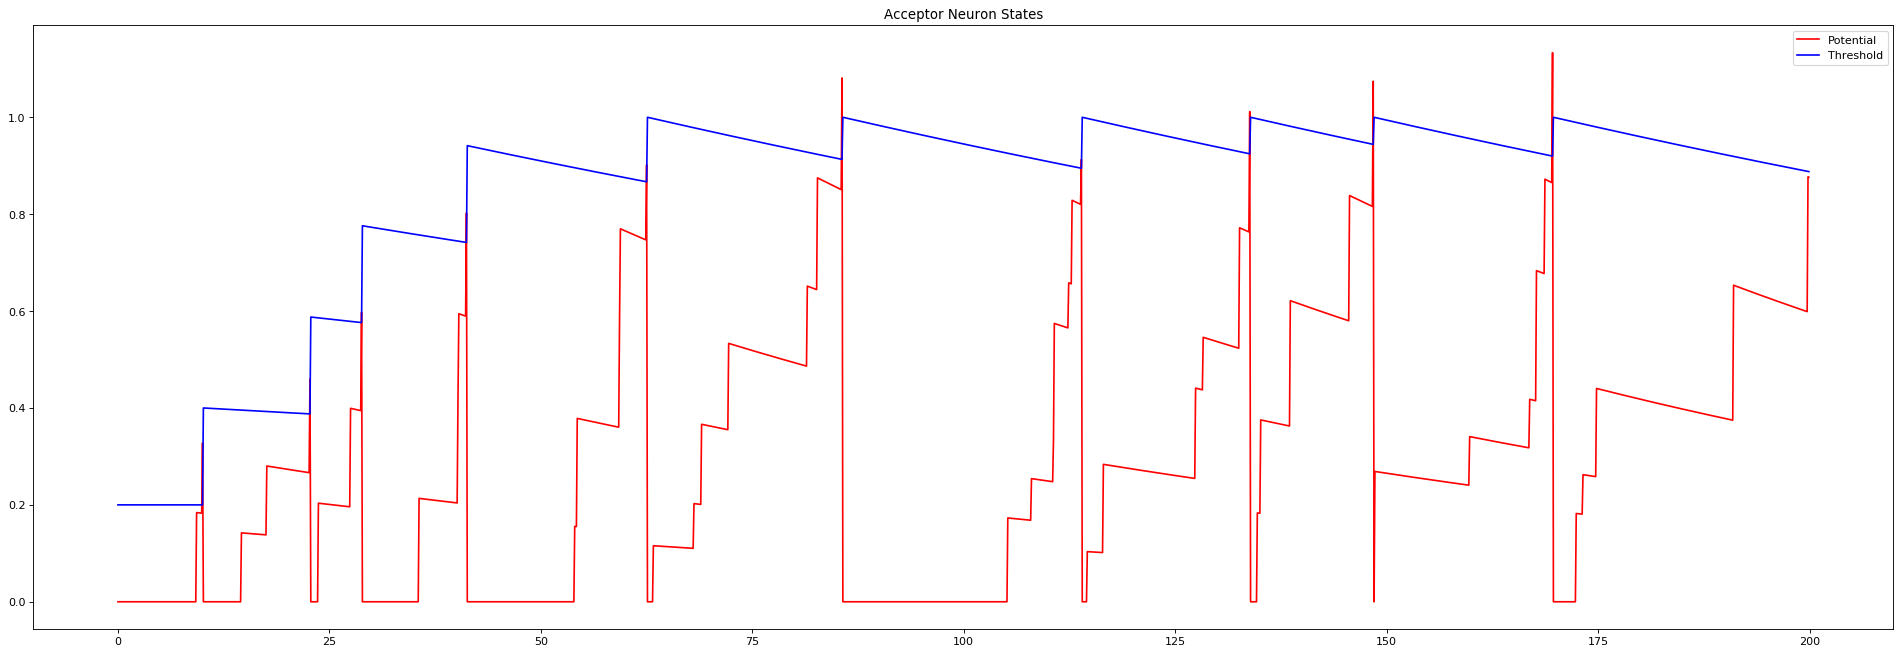

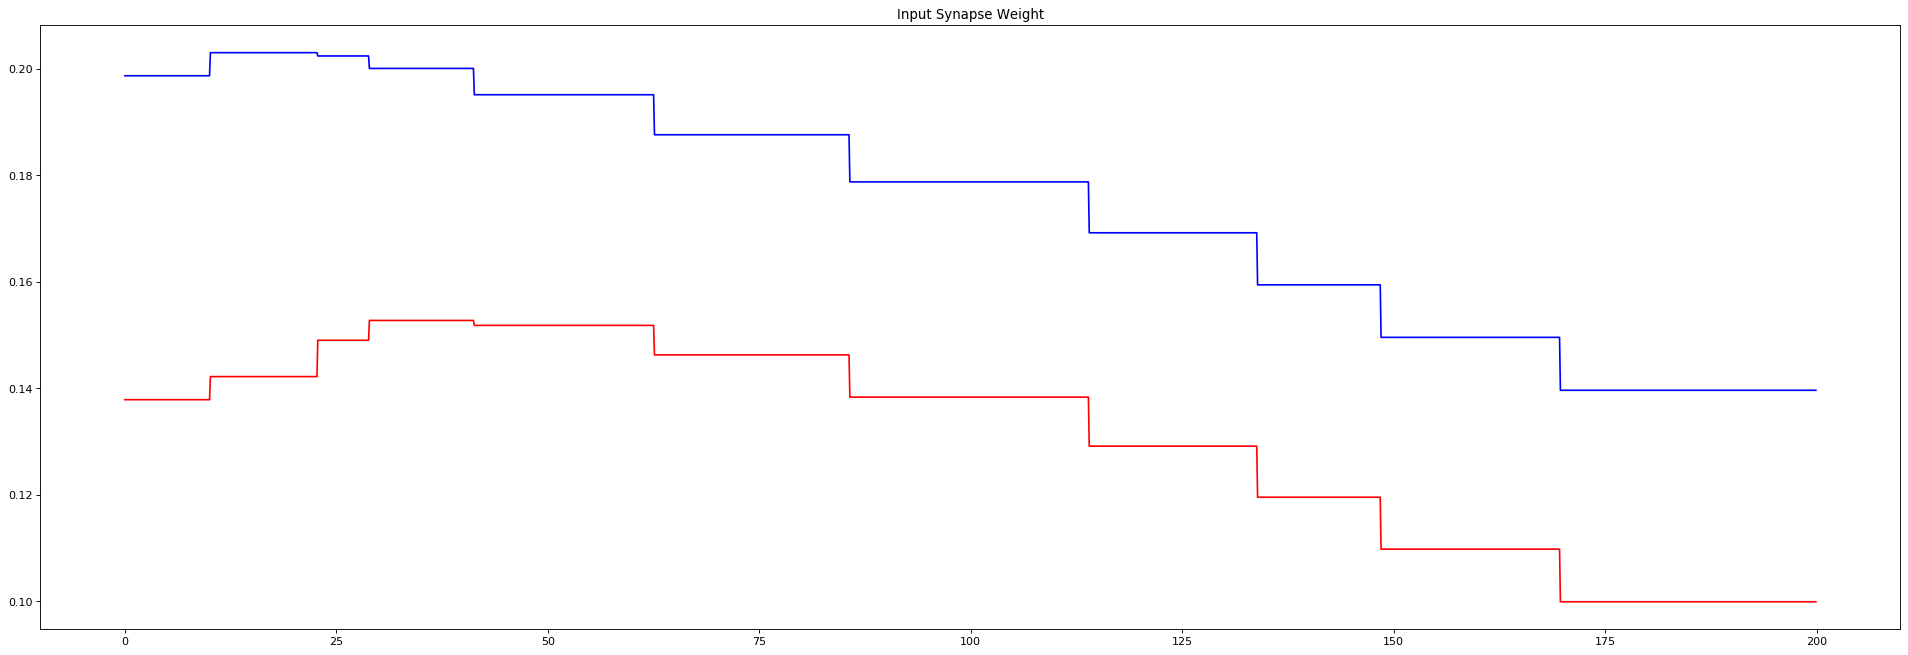

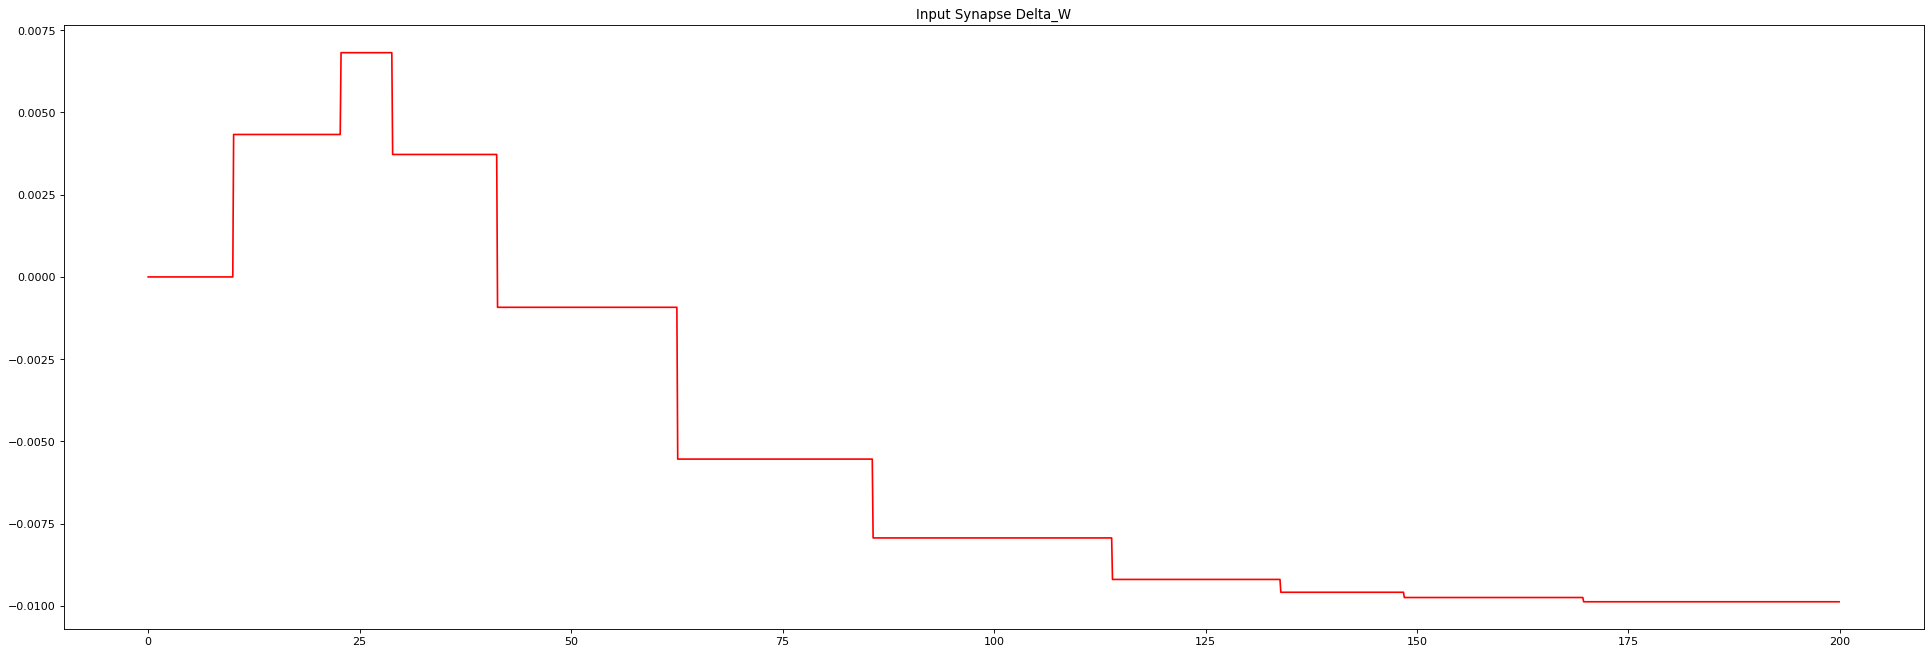

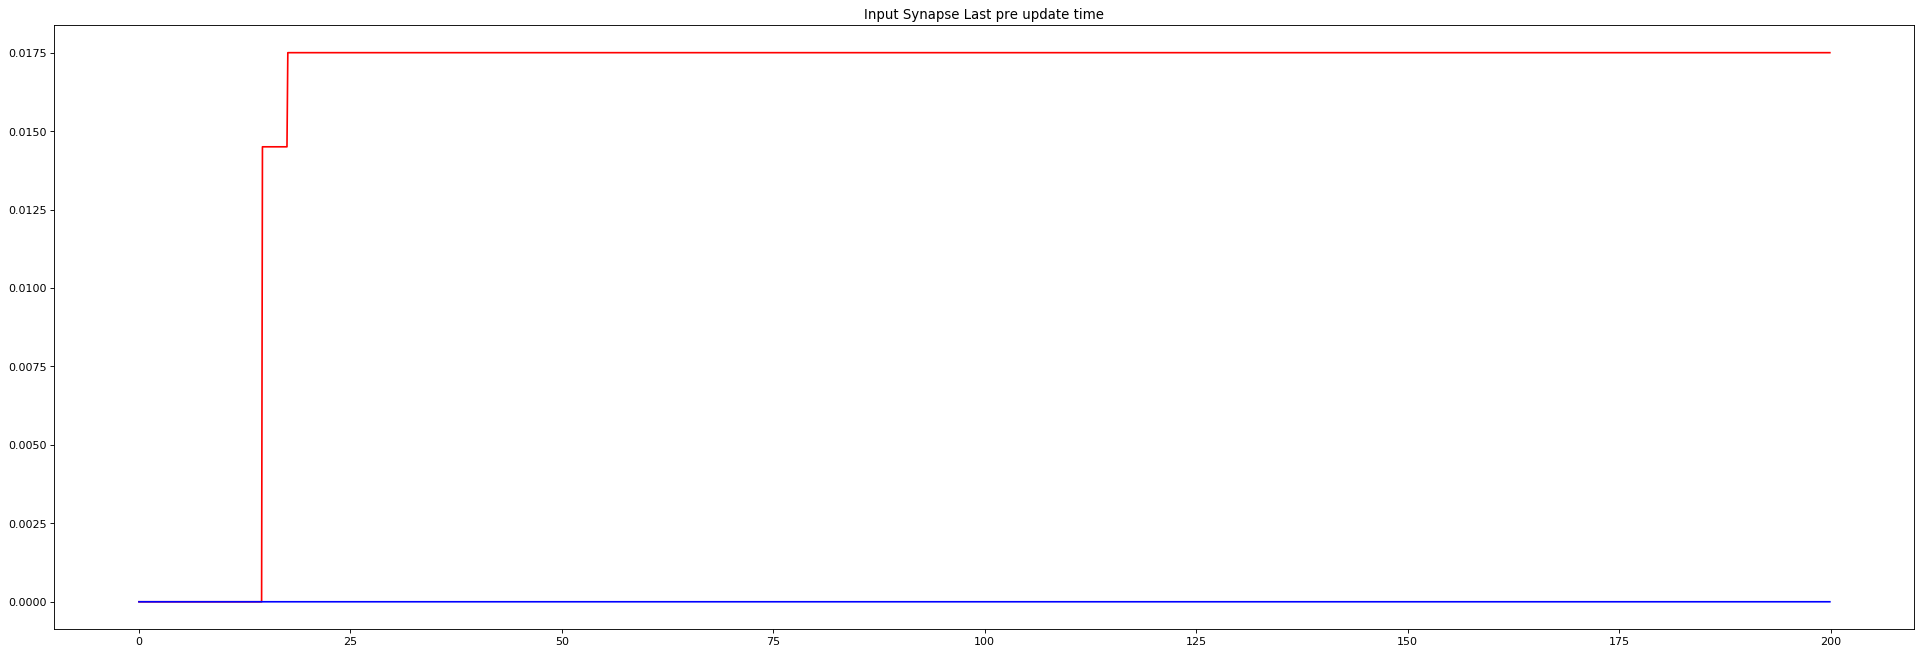

In [105]:
figure(figsize = (30, 10), dpi=80, facecolor = 'w', edgecolor = 'k')
plot(input_spike.t/ms, input_spike.i, '.r', ms=10)
plot(exc_spike.t/ms, exc_spike.i + 2, '.g', ms=10)
title("Spikes")

figure(figsize = (30, 10), dpi=80, facecolor = 'w', edgecolor = 'k')
plot(exc_v.t/ms, exc_v.v[0], "r")
plot(exc_vt.t/ms, exc_vt.vt_exc[0], "b")
title("Acceptor Neuron States")
legend({"Potential", "Threshold"})

figure(figsize = (30, 10), dpi=80, facecolor = 'w', edgecolor = 'k')
plot(input_w.t/ms, input_w.w[0], 'r', ms=5)
plot(input_w.t/ms, input_w.w[1], 'b', ms=5)
title("Input Synapse Weight")

figure(figsize = (30, 10), dpi=80, facecolor = 'w', edgecolor = 'k')
plot(delta_w_mo.t/ms, delta_w_mo.delta_w[0], 'r', ms=5)
title("Input Synapse Delta_W")

figure(figsize = (30, 10), dpi=80, facecolor = 'w', edgecolor = 'k')
plot(pre_update_t.t/ms, pre_update_t.pre_last[0], 'r', ms=5)
plot(pre_update_t.t/ms, pre_update_t.pre_last[1], 'b', ms=5)
title("Input Synapse Last pre update time")